# GPT Model implementation

the idea is to follow GPT 2 architecture and connect previous processes

Training Text >> Tokenization and Embedding >> Attention Mech >> GPT Architecture

In [3]:
GPT_CONFIG_124M = {
        "vocab_size": 50257,
        "context_length": 1024, 
        "emb_dim": 768, 
        "n_heads": 12, 
        "n_layers": 12, 
        "drop_rate": 0.1, 
        "qkv_bias": False  
}

import torch
import torch.nn as nn

In [4]:


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )

        self.final_norm = DummyLayerNorm(cfg['emb_dim'])

        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embds = self.tok_emb(in_idx)
        pos_embds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        x = tok_embds + pos_embds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)

        logits = self.out_head(x)
        return logits

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
    def forward(self, x):
        return x
    
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x

## Data Initialization and token preparation

In [22]:
# Process example
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch=[]

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))

batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [29]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)

print(logits.shape)
print(logits)

torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


In [42]:
torch.manual_seed(123)

batch_example = torch.randn(2,5)

layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_example)
print(out)

mean = out.mean(dim=-1, keepdim=True)
variance = out.var(dim=-1, keepdim=True)
print('mean', mean )
print('variance', variance )

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
mean tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
variance tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [38]:
#applying normalization layer
out_norm = (out - mean) / torch.sqrt(variance)

mean = out_norm.mean(dim=-1, keepdim=True)
variance = out_norm.var(dim=-1, keepdim=True)

print('normalized mean', mean )
print('normalized variance', variance )

normalized mean tensor([[    -0.0000],
        [    -0.0000]], grad_fn=<MeanBackward1>)
normalized variance tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [5]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [6]:
# activation function
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        htang = torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
                           (x + 0.044715 * torch.pow(x, 3)))
        return 0.5 * x * (1 + htang ) 
    

In [44]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True, unbiased=False)

print('mean', mean )
print('variance', var )

mean tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
variance tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


### how a gelu func works

In [1]:
import numpy as py
import matplotlib.pyplot as plt

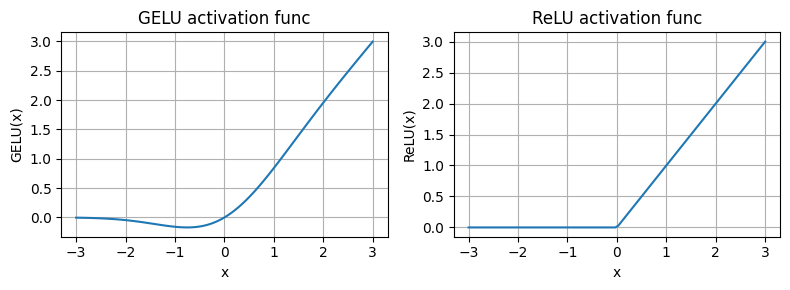

In [7]:


gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8,3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1,2,i)
    plt.plot(x,y)
    plt.title(f'{label} activation func')
    plt.xlabel('x')
    plt.ylabel(f'{label}(x)')
    plt.grid(True)

plt.tight_layout()
plt.show()
